In [13]:
from cProfile import label

# class that inherits from property based test
import numpy as np
import csv
import pandas as pd

pd.options.display.width = 240
import seaborn as sns
import scipy
import os
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylabel
from numpy.f2py.cb_rules import cb_map
from qiskit import QuantumCircuit
from sympy.printing.pretty.pretty_symbology import line_width

from qucheck.property import Property
from qucheck.input_generators import RandomState
from qucheck.test_runner import TestRunner

In [14]:
def read_merged_data_to_dataframe(algorithm_name):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{algorithm_name}_merged_results.csv"
    return pd.read_csv(filename)

def clean(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum()/10.0).reset_index(name='Result')
        return df
    

In [15]:
qt_df = read_merged_data_to_dataframe("quantum_teleportation")
dj_df = read_merged_data_to_dataframe("deutsch_jozsa")
qft_df = read_merged_data_to_dataframe("quantum_fourier_transform")
qpe_df = read_merged_data_to_dataframe("quantum_phase_estimation")
grover_df = read_merged_data_to_dataframe("grovers_algorithm")

all_df = [qt_df, dj_df, qft_df, qpe_df, grover_df]
all_df = pd.concat(all_df)

qt_df_c = clean([qt_df])
dj_df_c = clean([dj_df])
qft_df_c = clean([qft_df])
qpe_df_c = clean([qpe_df])
grover_df_c = clean([grover_df])
all_df_c = clean([all_df])

all_df_c

,Number of Measurements,Number of Inputs,Number of Properties,Equivalent,Algorithm,Result
0,12,1,1,False,deutsch_jozsa,0.2
1,12,1,1,False,grovers_algorithm,0.7
2,12,1,1,False,quantum_fourier_transform,0.1
3,12,1,1,False,quantum_phase_estimation,0.3
4,12,1,1,False,quantum_teleportation,0.3
...,...,...,...,...,...,...
1885,3200,64,3,True,deutsch_jozsa,0.0
1886,3200,64,3,True,grovers_algorithm,0.0
1887,3200,64,3,True,quantum_fourier_transform,0.0
1888,3200,64,3,True,quantum_phase_estimation,0.0


In [4]:
def get_correlation_coefficient(df, group_by="Number of Properties"):
    failure_rate = df[df['Equivalent'] == False]
    pass_rate = df[df['Equivalent'] == True]
        
    r1 = scipy.stats.spearmanr(failure_rate[group_by], failure_rate["Result"], alternative='two-sided')
    r2 = scipy.stats.spearmanr(pass_rate[group_by], pass_rate["Result"], alternative='two-sided')
        
    return r1, r2

In [5]:
# get the standard deviation of data for all algorithms from 1-3 properties and 50-3200 measurements, and 1-64 inputs
def get_stats(df, group_by="Number of Properties", filter_by_feature=None, filter_by_values=None):
    failure_rate = df[df['Equivalent'] == False]
    pass_rate = df[df['Equivalent'] == True]
    
    if filter_by_feature is not None:
        for i in range(len(filter_by_feature)):
            failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
            pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]
        
    print("Not Equivalent")
    
    if group_by is not None:
        print("STD NE")
        print(failure_rate.groupby(group_by)['Result'].std())
        print("Median NE")
        print(failure_rate.groupby(group_by)['Result'].median())
        print("Mean NE")
        print(failure_rate.groupby(group_by)['Result'].mean())
        print("Pearson Correlation Coefficient NE")
        print(scipy.stats.spearmanr(failure_rate[group_by], failure_rate["Result"], alternative='two-sided'))
    else:
        print("STD NE")
        print(failure_rate['Result'].std())
        print("Median NE")
        print(failure_rate['Result'].median())
        print("Mean NE")
        print(failure_rate['Result'].mean())
    
    print("Equivalent")
    
    if group_by is not None:
        print("STD E")
        print(pass_rate.groupby(group_by)['Result'].std())
        print("Median E")
        print(pass_rate.groupby(group_by)['Result'].median())
        print("Mean E")
        print(pass_rate.groupby(group_by)['Result'].mean())
        print("Pearson Correlation Coefficient E")
        print(scipy.stats.spearmanr(pass_rate[group_by], pass_rate["Result"], alternative='two-sided'))
    else:
        print("STD E")
        print(pass_rate['Result'].std())
        print("Median E")
        print(pass_rate['Result'].median())
        print("Mean E")
        print(pass_rate['Result'].mean())

# get_stats(all_df_c, group_by="Number of Measurements")
# get_standard_deviation(qt_df, divide_multiplier=1, group_by="Number of Properties")

Not Equivalent
STD NE
Number of Properties
1    0.223334
2    0.202358
3    0.156862
Name: Result, dtype: float64
Median NE
Number of Properties
1    0.6
2    0.8
3    0.9
Name: Result, dtype: float64
Mean NE
Number of Properties
1    0.554286
2    0.762540
3    0.852063
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.5323913674589874, pvalue=2.745390619365338e-70)
Equivalent
STD E
Number of Properties
1    0.058223
2    0.108012
3    0.141029
Name: Result, dtype: float64
Median E
Number of Properties
1    0.0
2    0.0
3    0.0
Name: Result, dtype: float64
Mean E
Number of Properties
1    0.022222
2    0.046349
3    0.061587
Name: Result, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.0765986920579574, pvalue=0.0185200535604627)


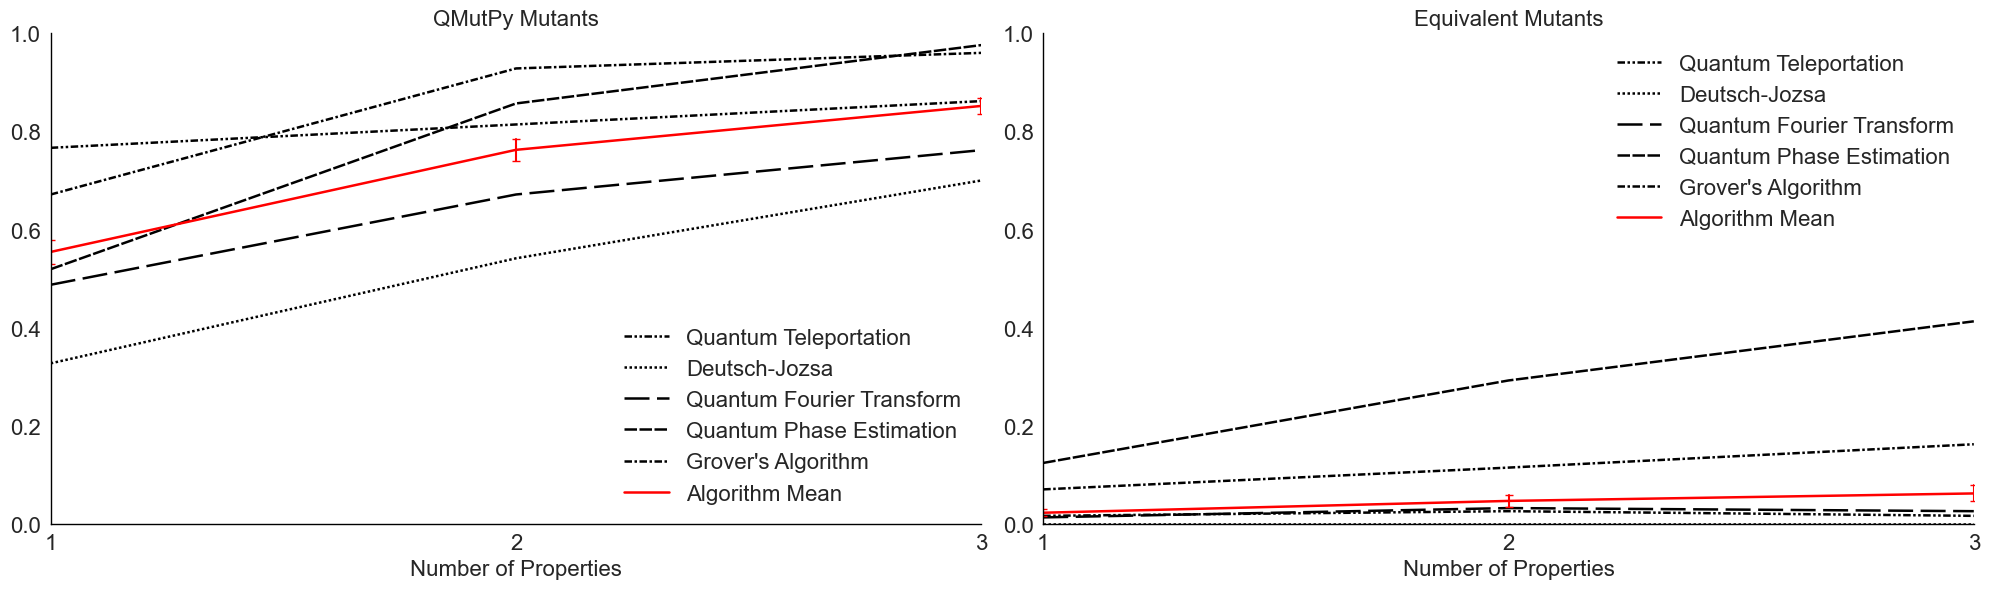

In [6]:
def plot_linegraph(dfs, dfs_names, feature_str, log_scale=False, cleaned_data=None, filter_by_feature=None, filter_by_values=None):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (3, 1, 1, 1, 1, 1),       # solid line
        (1, 1),             # dashed line
        (10, 3),      # dash-dot line
        (5, 1),             # dotted line
        (3, 1, 1, 1)      # dash-dot-dot line
    ]
    
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.title.set_text(f'QMutPy Mutants')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Equivalent Mutants')
    ax2.title.set_fontsize(16)
    
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
    
    if feature_str == "Number of Measurements":
        ticks = [12, 25, 50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]
        
    ax1.set_xlim(ticks[0], ticks[-1])
    
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()
    
    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]
        
        # apply filters
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                df_non_equivalent = df_non_equivalent[df_non_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]
                df_equivalent = df_equivalent[df_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]

        df_non_equivalent = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        failure_rate = df_non_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        failure_rate['Result'] = failure_rate['Result']/10.0
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])
        
        df_equivalent = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        pass_rate = df_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        pass_rate['Result'] = pass_rate['Result']/5.0
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        idx += 1
    
    if cleaned_data is not None:
        failure_rate = cleaned_data[cleaned_data['Equivalent'] == False]
        pass_rate = cleaned_data[cleaned_data['Equivalent'] == True]
        
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
                pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]
        
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)
        
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)
    

    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()
    
    plt.tight_layout()
    if filter_by_feature is not None:
        plt.savefig(f"{feature_str.replace(' ', '_')}_{filter_by_feature[0].replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
    else:
        plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]


get_stats(all_df_c, group_by="Number of Properties")
plot_linegraph(dfs, dfs_names, "Number of Properties", log_scale=False, cleaned_data=all_df_c)

# Varying properties, (800, 1600, 3200) measurements

Not Equivalent
STD NE
Number of Properties
1    0.215145
2    0.152404
3    0.104496
Name: Result, dtype: float64
Median NE
Number of Properties
1    0.6
2    0.8
3    0.9
Name: Result, dtype: float64
Mean NE
Number of Properties
1    0.579048
2    0.784762
3    0.881905
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.607388411037276, pvalue=3.8121048909708607e-33)
Equivalent
STD E
Number of Properties
1    0.023323
2    0.041888
3    0.025064
Name: Result, dtype: float64
Median E
Number of Properties
1    0.0
2    0.0
3    0.0
Name: Result, dtype: float64
Mean E
Number of Properties
1    0.005714
2    0.016190
3    0.006667
Name: Result, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.013571710414986714, pvalue=0.8103865259326123)


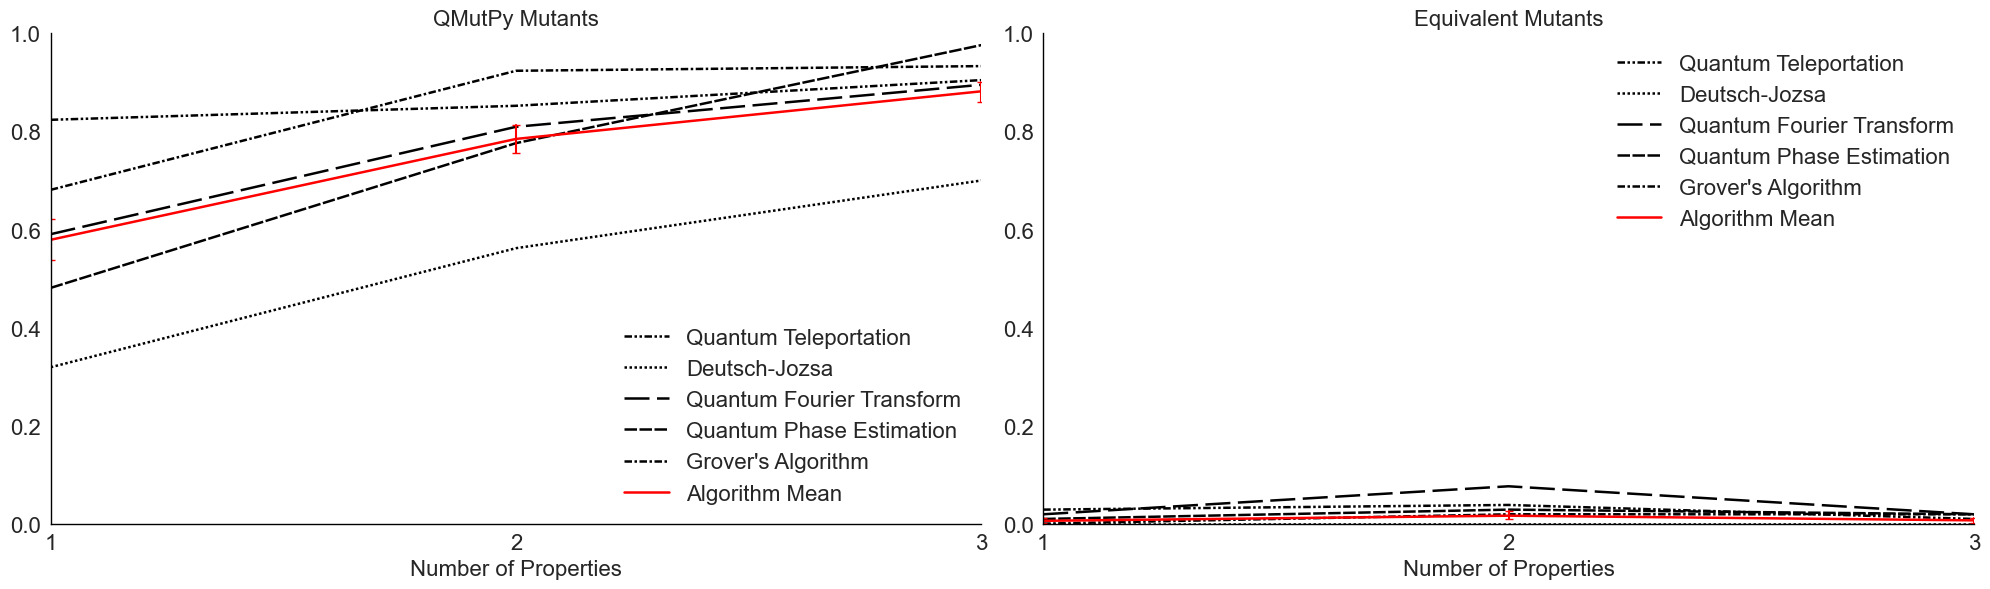

In [8]:
get_stats(all_df_c, group_by="Number of Properties", filter_by_feature=['Number of Measurements'], filter_by_values=[[800, 1600, 3200]])
plot_linegraph(dfs, dfs_names, "Number of Properties", log_scale=False, cleaned_data=all_df_c, filter_by_feature=['Number of Measurements'], filter_by_values=[[800, 1600, 3200]])

# Changing Number of Inputs

Not Equivalent
STD NE
Number of Inputs
1     0.231112
2     0.252707
4     0.228776
8     0.235463
16    0.227192
32    0.209785
64    0.219520
Name: Result, dtype: float64
Median NE
Number of Inputs
1     0.7
2     0.8
4     0.8
8     0.8
16    0.8
32    0.8
64    0.8
Name: Result, dtype: float64
Mean NE
Number of Inputs
1     0.651111
2     0.682222
4     0.722222
8     0.724444
16    0.747407
32    0.762222
64    0.771111
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.17262985451601845, pvalue=9.299596496079904e-08)
Equivalent
STD E
Number of Inputs
1     0.061607
2     0.074253
4     0.092762
8     0.109590
16    0.110404
32    0.129561
64    0.145836
Name: Result, dtype: float64
Median E
Number of Inputs
1     0.0
2     0.0
4     0.0
8     0.0
16    0.0
32    0.0
64    0.0
Name: Result, dtype: float64
Mean E
Number of Inputs
1     0.012593
2     0.022963
4     0.031852
8     0.042222
16    0.044444
32    0.068889
64    0.080741
Name:

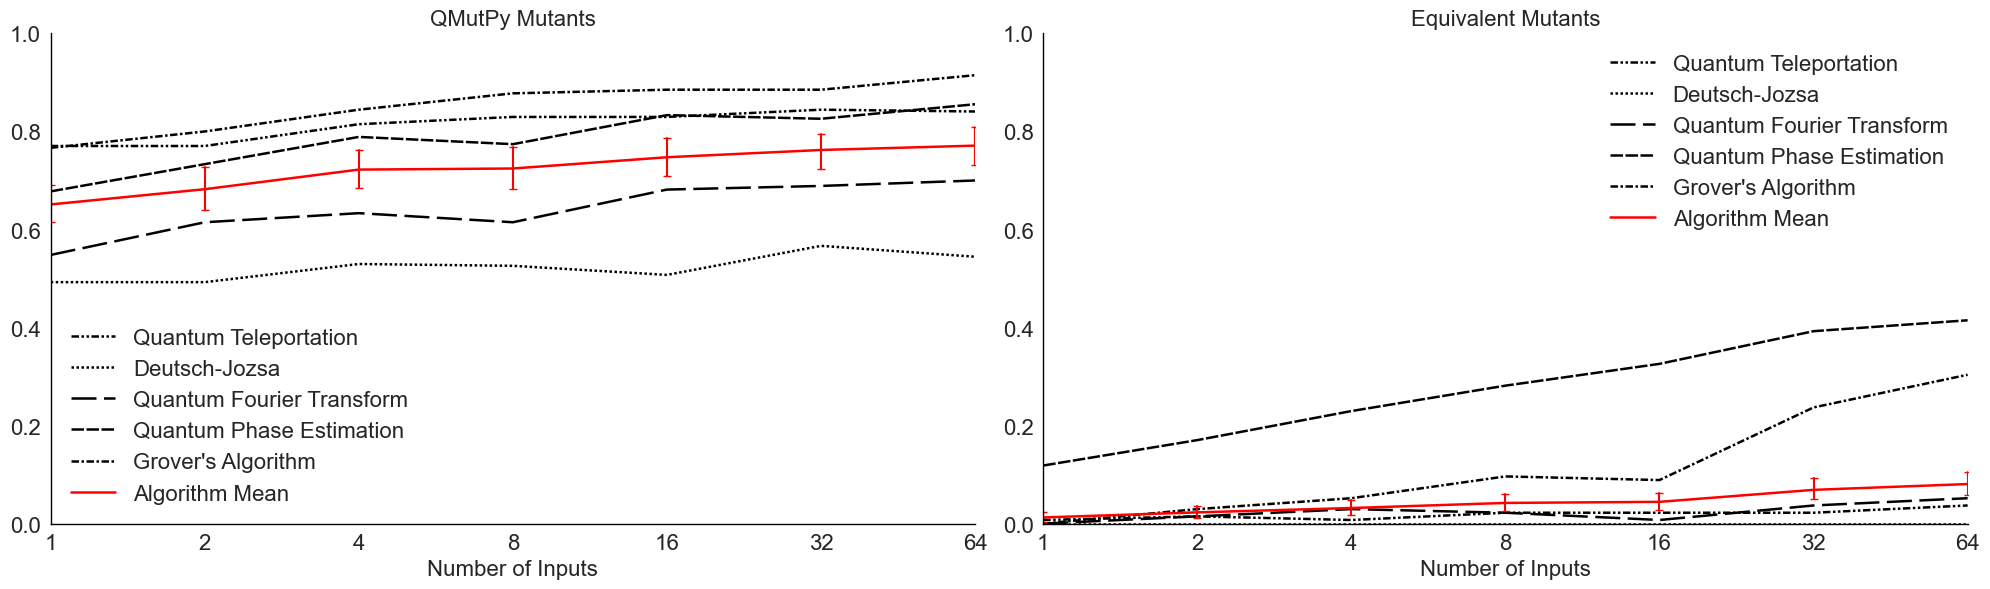

In [9]:
get_stats(all_df_c, group_by="Number of Inputs")
plot_linegraph(dfs, dfs_names, "Number of Inputs", log_scale=True, cleaned_data=all_df_c)

# Changing Number of Inputs, (800, 1600, 3200) measurements and 3 properties

Not Equivalent
STD NE
Number of Inputs
1     0.099043
2     0.097590
4     0.101419
8     0.101419
16    0.109978
32    0.113389
64    0.116292
Name: Result, dtype: float64
Median NE
Number of Inputs
1     0.9
2     0.9
4     0.9
8     0.9
16    0.9
32    0.9
64    0.9
Name: Result, dtype: float64
Mean NE
Number of Inputs
1     0.846667
2     0.866667
4     0.880000
8     0.880000
16    0.893333
32    0.900000
64    0.906667
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.2392669622256899, pvalue=0.013962546214054168)
Equivalent
STD E
Number of Inputs
1     0.000000
2     0.000000
4     0.041404
8     0.025820
16    0.000000
32    0.035187
64    0.025820
Name: Result, dtype: float64
Median E
Number of Inputs
1     0.0
2     0.0
4     0.0
8     0.0
16    0.0
32    0.0
64    0.0
Name: Result, dtype: float64
Mean E
Number of Inputs
1     0.000000
2     0.000000
4     0.020000
8     0.006667
16    0.000000
32    0.013333
64    0.006667
Name: R

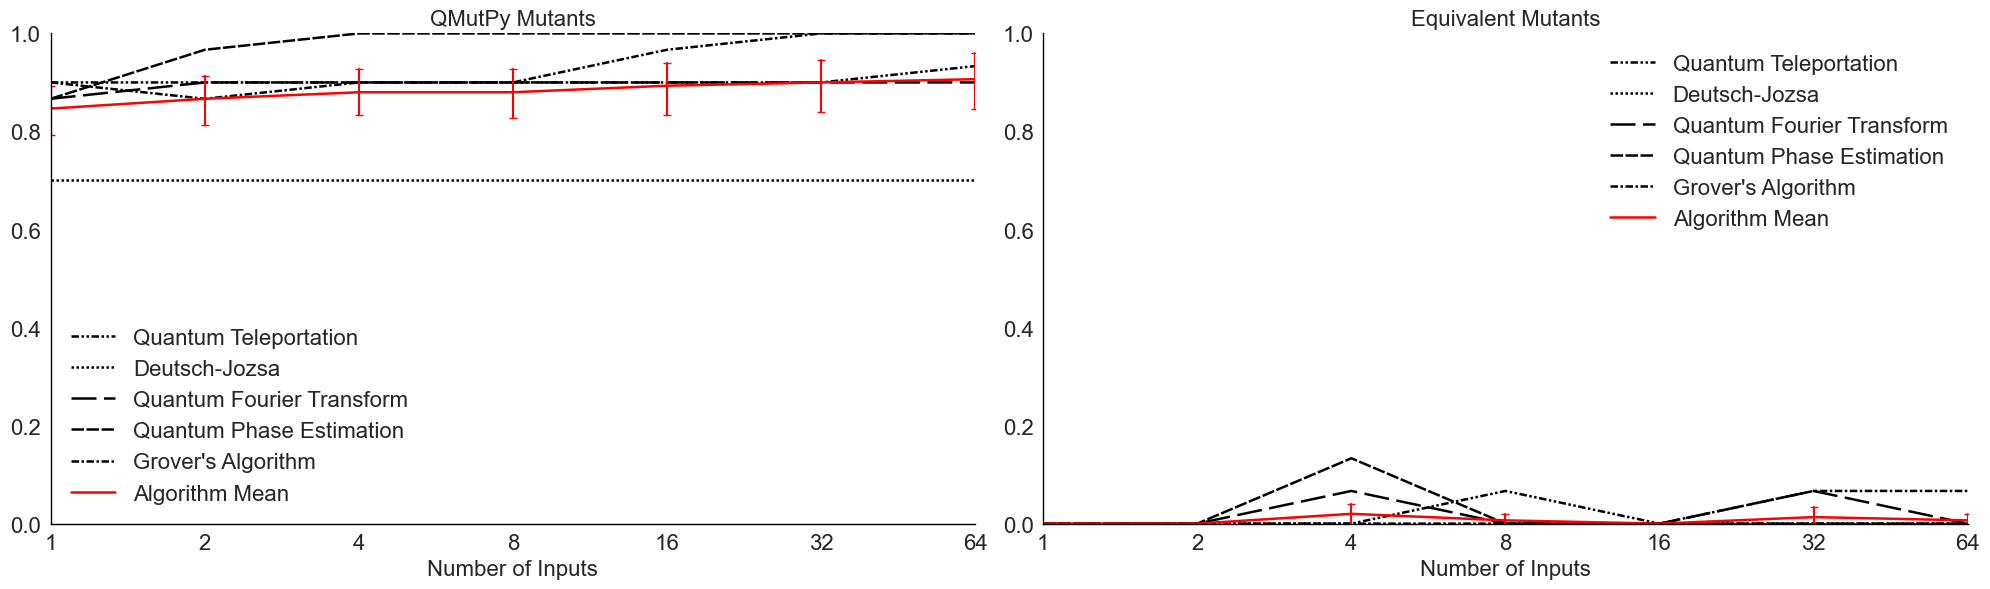

In [10]:
get_stats(all_df_c, group_by="Number of Inputs", filter_by_feature=['Number of Properties', 'Number of Measurements'], filter_by_values=[[3], [800,  1600, 3200]])
plot_linegraph(dfs, dfs_names, "Number of Inputs", log_scale=True, cleaned_data=all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements'], filter_by_values=[[3], [800, 1600, 3200]])

# Changing Number of Measurements

Not Equivalent
STD NE
Number of Measurements
12      0.272262
25      0.259853
50      0.230293
100     0.230829
200     0.213002
400     0.216672
800     0.213088
1600    0.207607
3200    0.200471
Name: Result, dtype: float64
Median NE
Number of Measurements
12      0.6
25      0.7
50      0.7
100     0.8
200     0.8
400     0.8
800     0.8
1600    0.8
3200    0.8
Name: Result, dtype: float64
Mean NE
Number of Measurements
12      0.602857
25      0.683810
50      0.715238
100     0.753333
200     0.756190
400     0.749524
800     0.751429
1600    0.749524
3200    0.744762
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.12070066078446125, pvalue=0.00019990610403280336)
Equivalent
STD E
Number of Measurements
12      0.163451
25      0.154125
50      0.144325
100     0.112595
200     0.083567
400     0.062165
800     0.026658
1600    0.035882
3200    0.031361
Name: Result, dtype: float64
Median E
Number of Measurements
12      0.0
25      

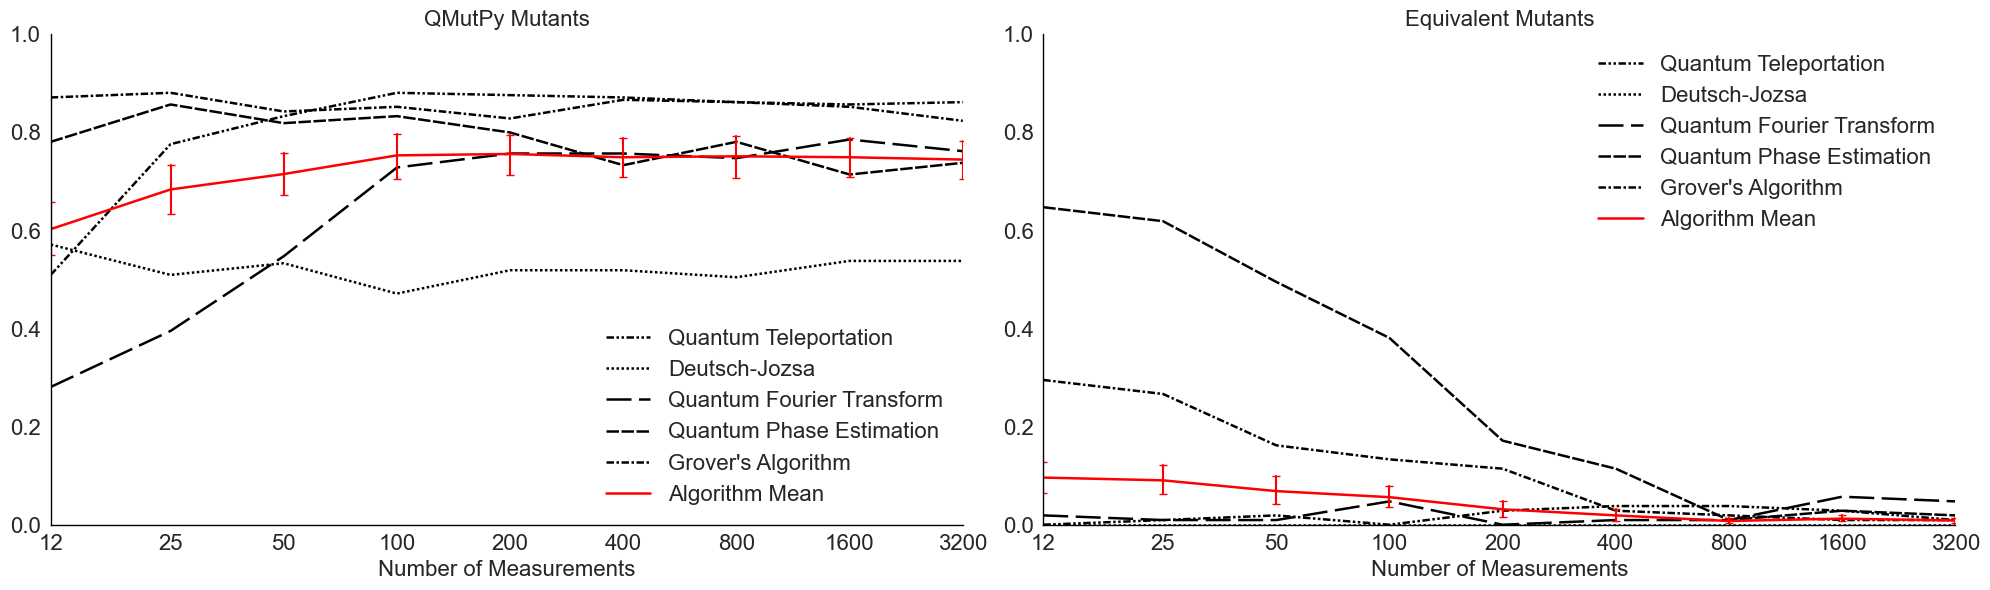

In [11]:
get_stats(all_df_c, group_by="Number of Measurements")
plot_linegraph(dfs, dfs_names, "Number of Measurements", log_scale=True, cleaned_data=all_df_c)

# Changing number of measurements, remove the equivalent mutants

Not Equivalent
STD NE
Number of Measurements
12      0.272262
25      0.259853
50      0.230293
100     0.230829
200     0.213002
400     0.216672
800     0.213088
1600    0.207607
3200    0.200471
Name: Result, dtype: float64
Median NE
Number of Measurements
12      0.6
25      0.7
50      0.7
100     0.8
200     0.8
400     0.8
800     0.8
1600    0.8
3200    0.8
Name: Result, dtype: float64
Mean NE
Number of Measurements
12      0.602857
25      0.683810
50      0.715238
100     0.753333
200     0.756190
400     0.749524
800     0.751429
1600    0.749524
3200    0.744762
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.12070066078446125, pvalue=0.00019990610403280336)
Equivalent
STD E
Number of Measurements
12      0.163451
25      0.154125
50      0.144325
100     0.112595
200     0.083567
400     0.062165
800     0.026658
1600    0.035882
3200    0.031361
Name: Result, dtype: float64
Median E
Number of Measurements
12      0.0
25      

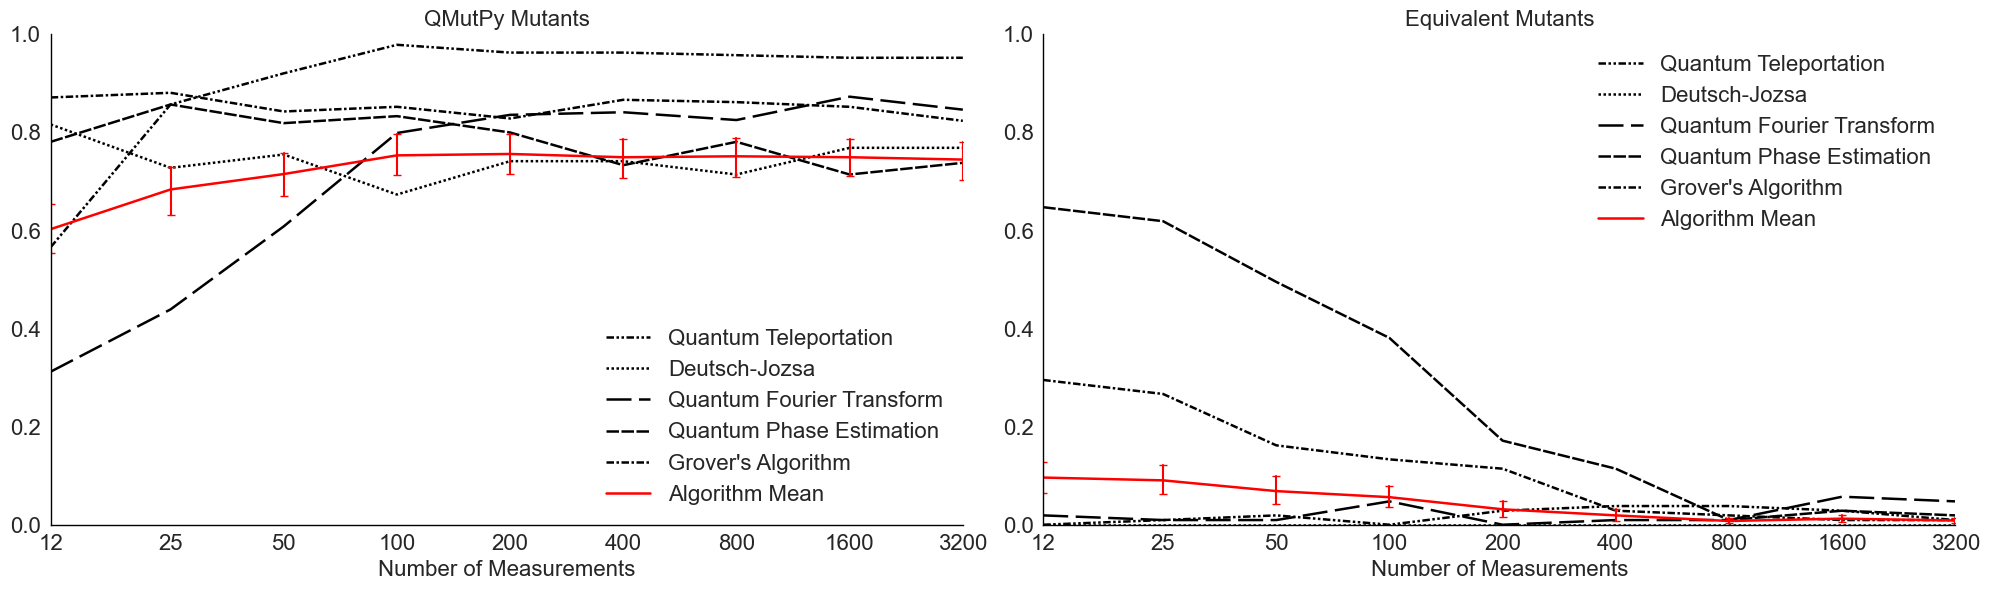

In [11]:
def plot_linegraph_rem_rows(dfs, dfs_names, feature_str, log_scale=False, cleaned_data=None, filter_by_feature=None, filter_by_values=None):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (3, 1, 1, 1, 1, 1),       # solid line
        (1, 1),             # dashed line
        (10, 3),      # dash-dot line
        (5, 1),             # dotted line
        (3, 1, 1, 1)      # dash-dot-dot line
    ]
    
    equivalent_mutants_in_ms = ["quantum_teleportation_m8",
                            "deutsch_jozsa_m1", "deutsch_jozsa_m2", "deutsch_jozsa_m7",
                            "quantum_fourier_transform_m9"
                            ] 
    
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.title.set_text(f'QMutPy Mutants')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Equivalent Mutants')
    ax2.title.set_fontsize(16)
    
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
    
    if feature_str == "Number of Measurements":
        ticks = [12, 25, 50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]
        
    ax1.set_xlim(ticks[0], ticks[-1])
    
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()
    
    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        # remove the equivalent mutants from list
        algorithm_df = algorithm_df[~algorithm_df['Mutant Name'].isin(equivalent_mutants_in_ms)]
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]
        
        # apply filters
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                df_non_equivalent = df_non_equivalent[df_non_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]
                df_equivalent = df_equivalent[df_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]

        divide_by = 10.0
        if algorithm_name == "Quantum Teleportation":
            divide_by = 9.0
        elif algorithm_name == "Deutsch-Jozsa":
            divide_by = 7.0
        elif algorithm_name == "Quantum Fourier Transform":
            divide_by = 9.0
            
        
        df_non_equivalent = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        failure_rate = df_non_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        failure_rate['Result'] = failure_rate['Result']/divide_by
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])
        
        df_equivalent = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        pass_rate = df_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        pass_rate['Result'] = pass_rate['Result']/5.0
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        idx += 1
    
    if cleaned_data is not None:
        failure_rate = cleaned_data[cleaned_data['Equivalent'] == False]
        failure_rate = failure_rate[~failure_rate['Algorithm'].isin(equivalent_mutants_in_ms)]
        pass_rate = cleaned_data[cleaned_data['Equivalent'] == True]
        
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
                pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]
        
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)
        
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)
    

    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()
    
    plt.tight_layout()
    if filter_by_feature is not None:
        plt.savefig(f"{feature_str.replace(' ', '_')}_{filter_by_feature[0].replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
    else:
        plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]


get_stats(all_df_c, group_by="Number of Measurements")
plot_linegraph_rem_rows(dfs, dfs_names, "Number of Measurements", log_scale=True, cleaned_data=all_df_c)

# Mutation score heatmap for each algorithm, and averaged heatmap

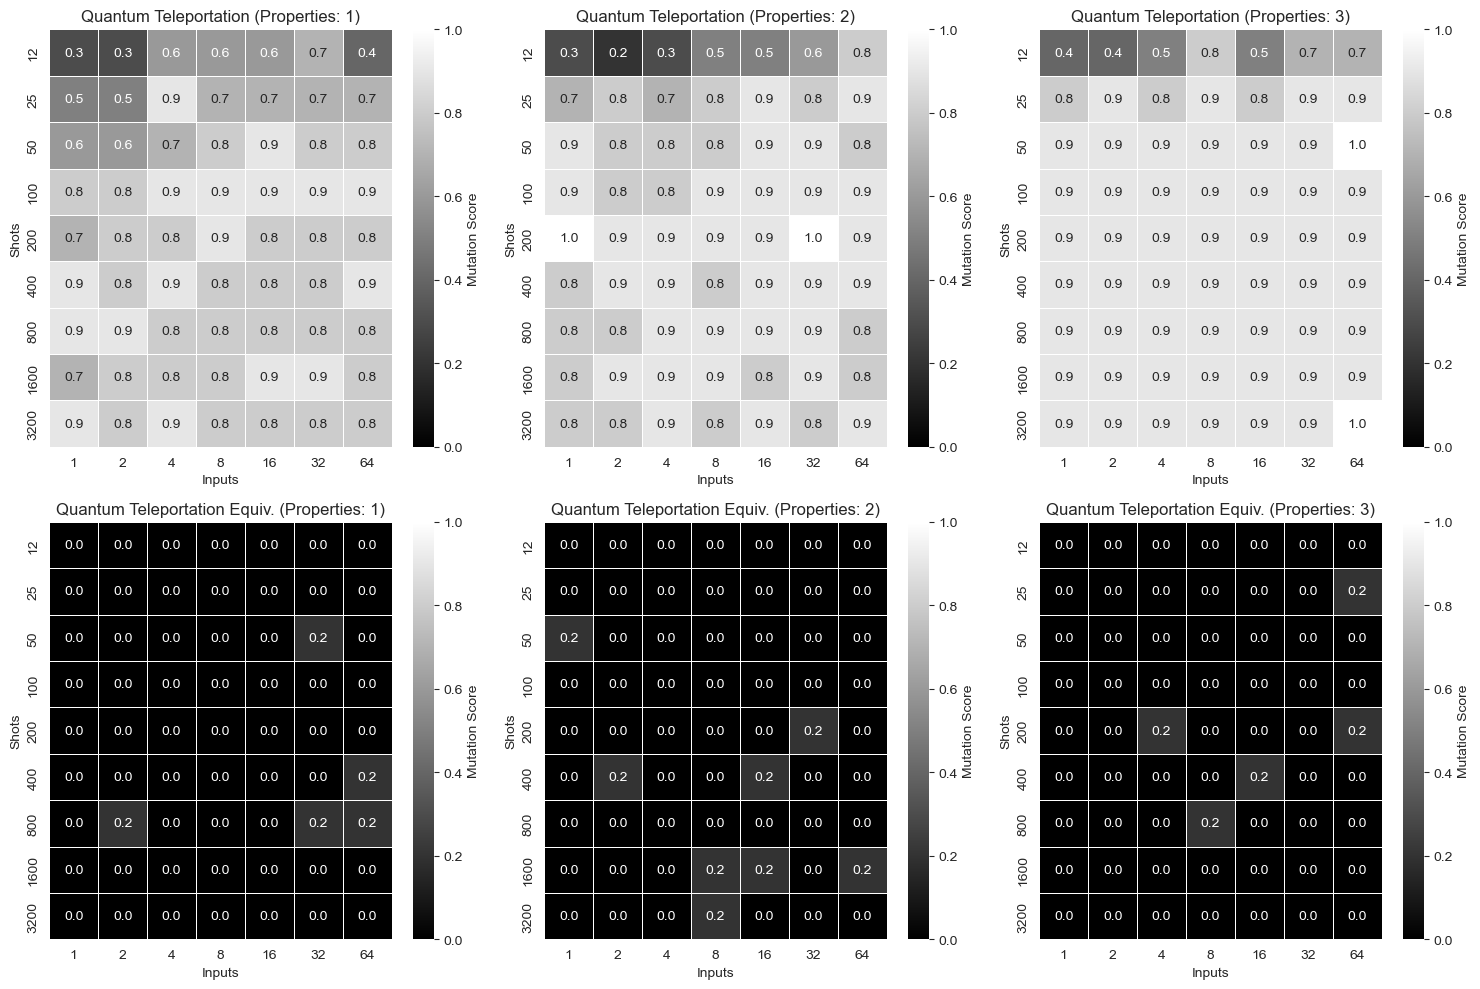

In [42]:
def plot_failures(df, algorithm_name, dp_format=".1f"):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # viridis or magma
    palette = sns.color_palette("gray", as_cmap=True)

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()
                
        grouped = df_subset.groupby(["Number of Measurements", "Number of Inputs"])
        result = grouped['Mutant Name'].nunique().reset_index()
        max_value = result['Mutant Name'].iloc[0]
        
        failure_rate = failure_rate / max_value

        sns.heatmap(failure_rate, annot=True, cmap=palette, ax=axes[0, i], fmt=dp_format, 
                    linewidth=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Mutation Score'}, 
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()
        
        grouped = df_subset.groupby(["Number of Measurements", "Number of Inputs"])
        result = grouped['Mutant Name'].nunique().reset_index()
        max_value = result['Mutant Name'].iloc[0]
        
        pass_rate = pass_rate / max_value
        
        sns.heatmap(pass_rate, annot=True, cmap=palette, ax=axes[1, i], fmt=dp_format, 
                    linewidth=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Mutation Score'}, 
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')

    plt.tight_layout()
    plt.savefig(f"{algorithm_name.replace(' ', '_')}_failures_heatmap.png", dpi=100, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_failures(qt_df, "Quantum Teleportation")

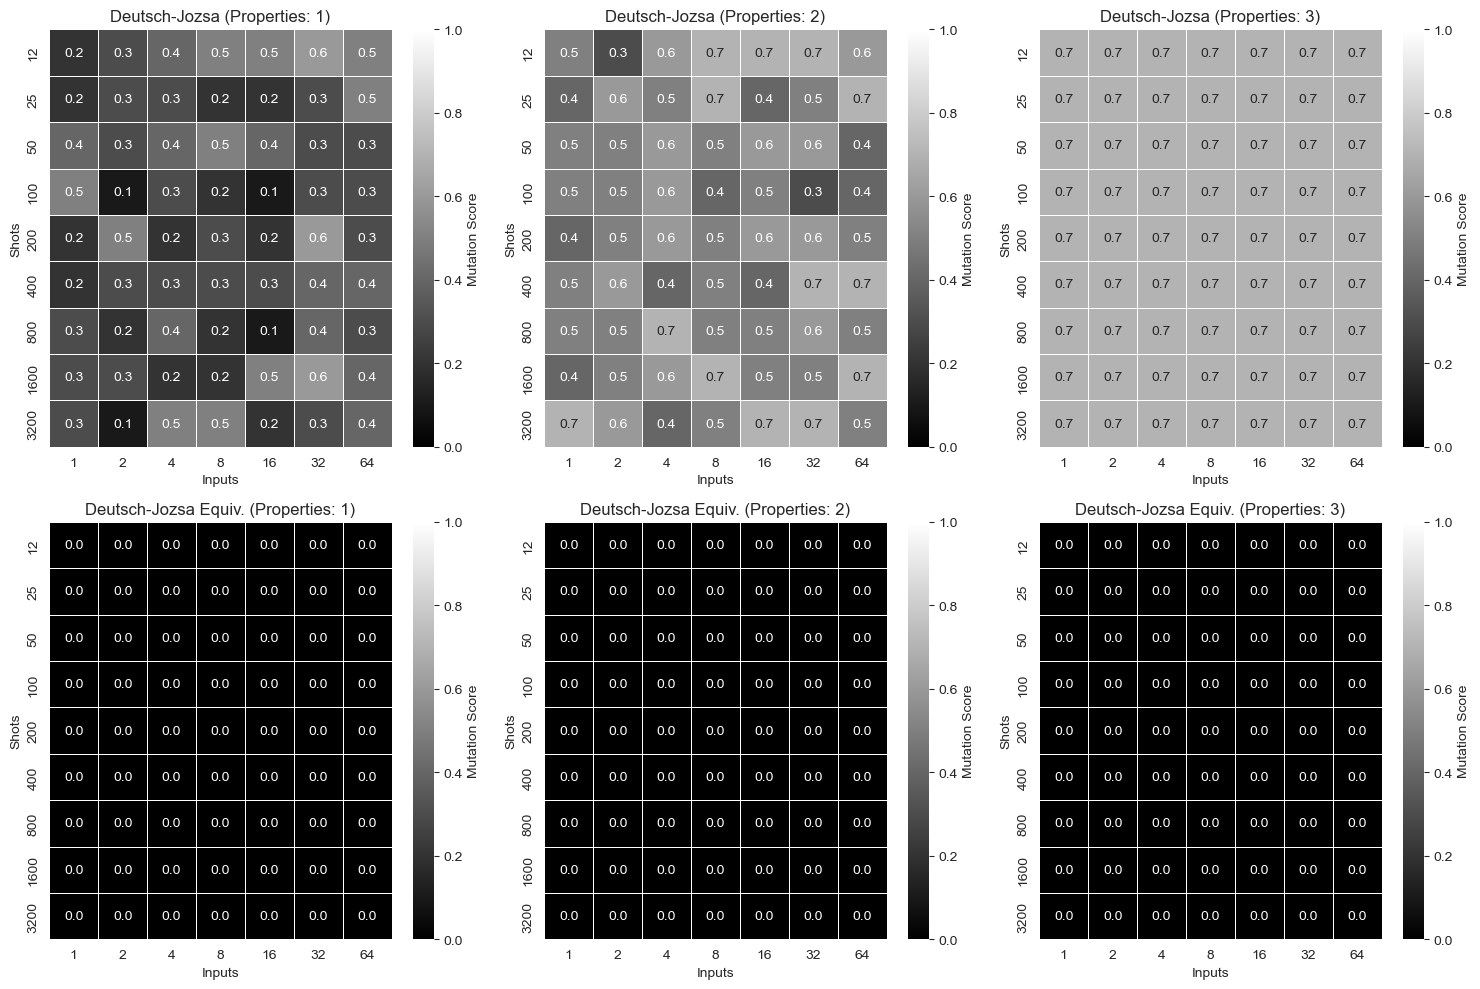

In [43]:
plot_failures(dj_df, "Deutsch-Jozsa")

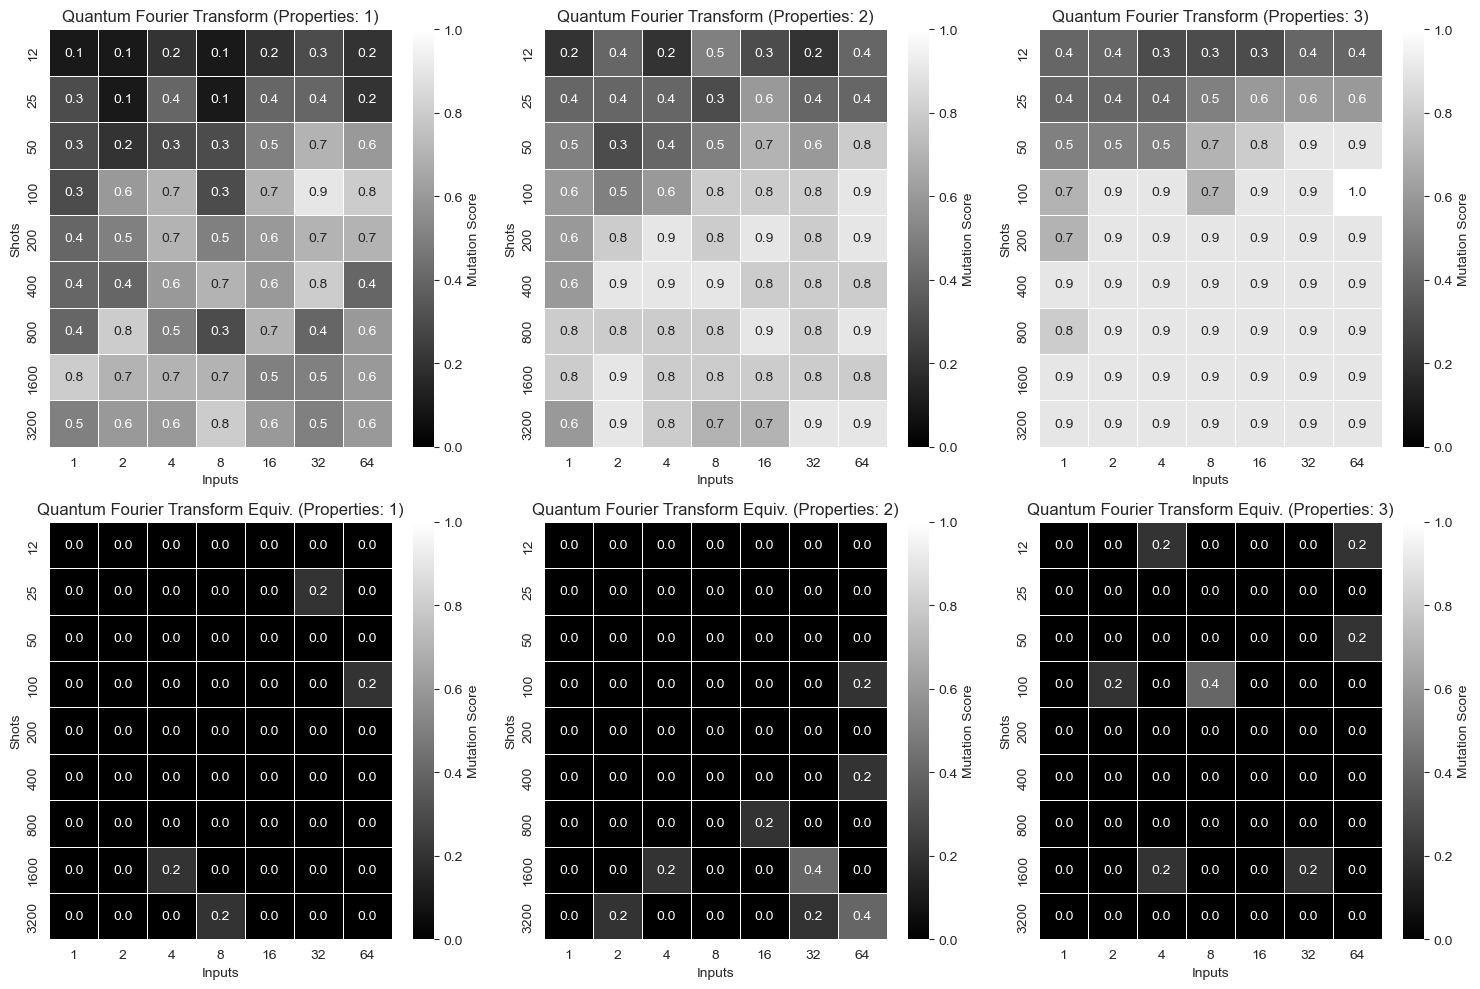

In [44]:
plot_failures(qft_df, "Quantum Fourier Transform")

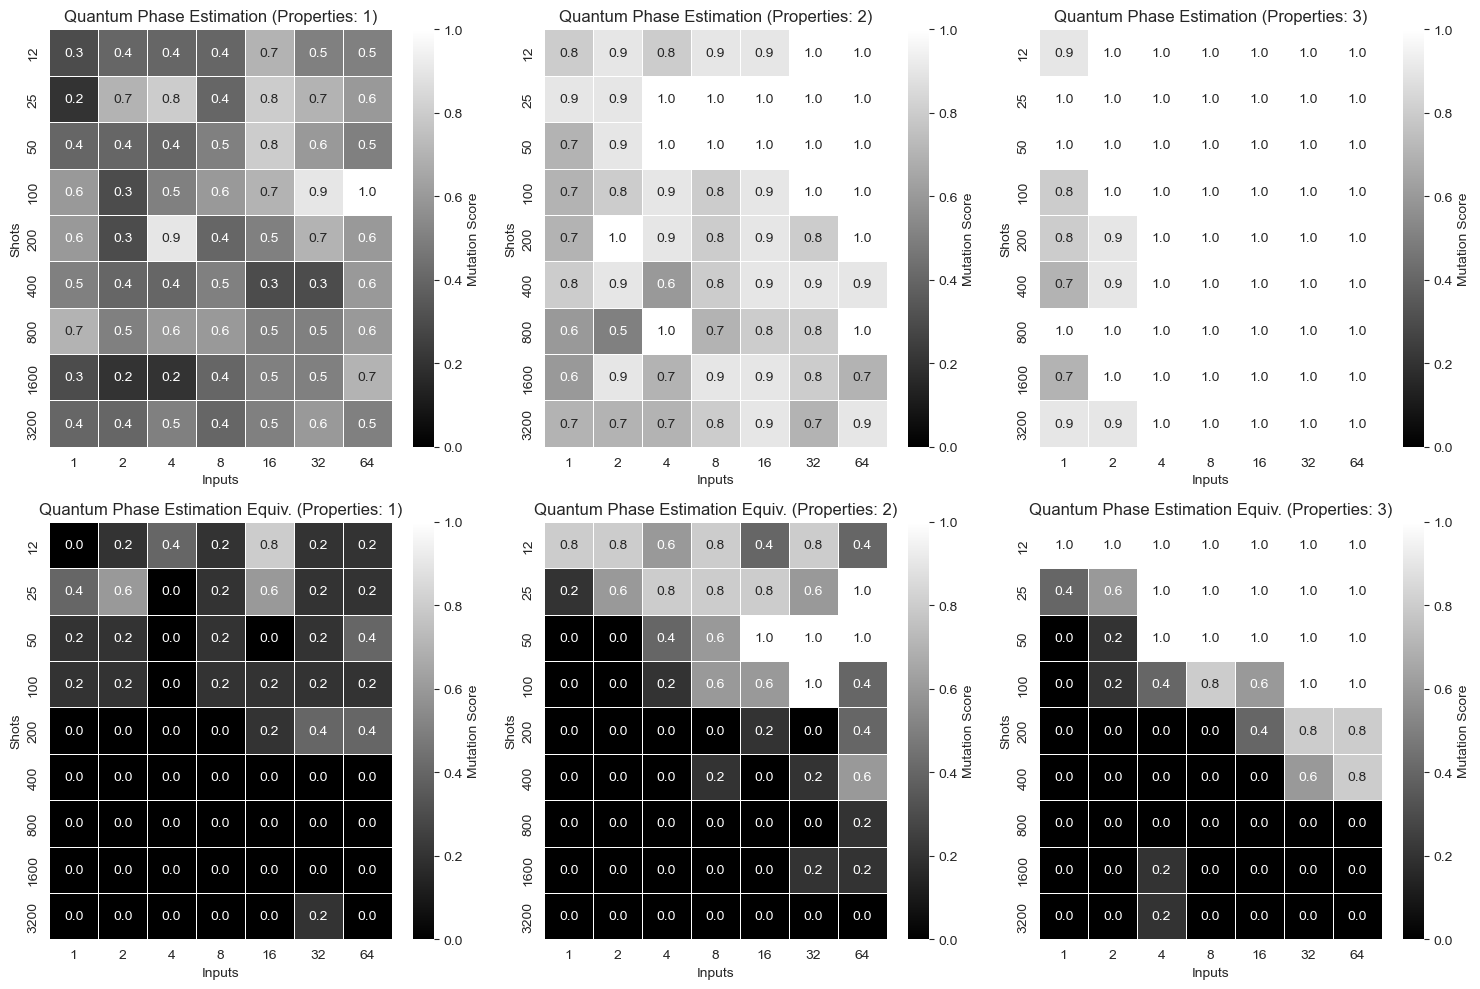

In [45]:
plot_failures(qpe_df, "Quantum Phase Estimation")

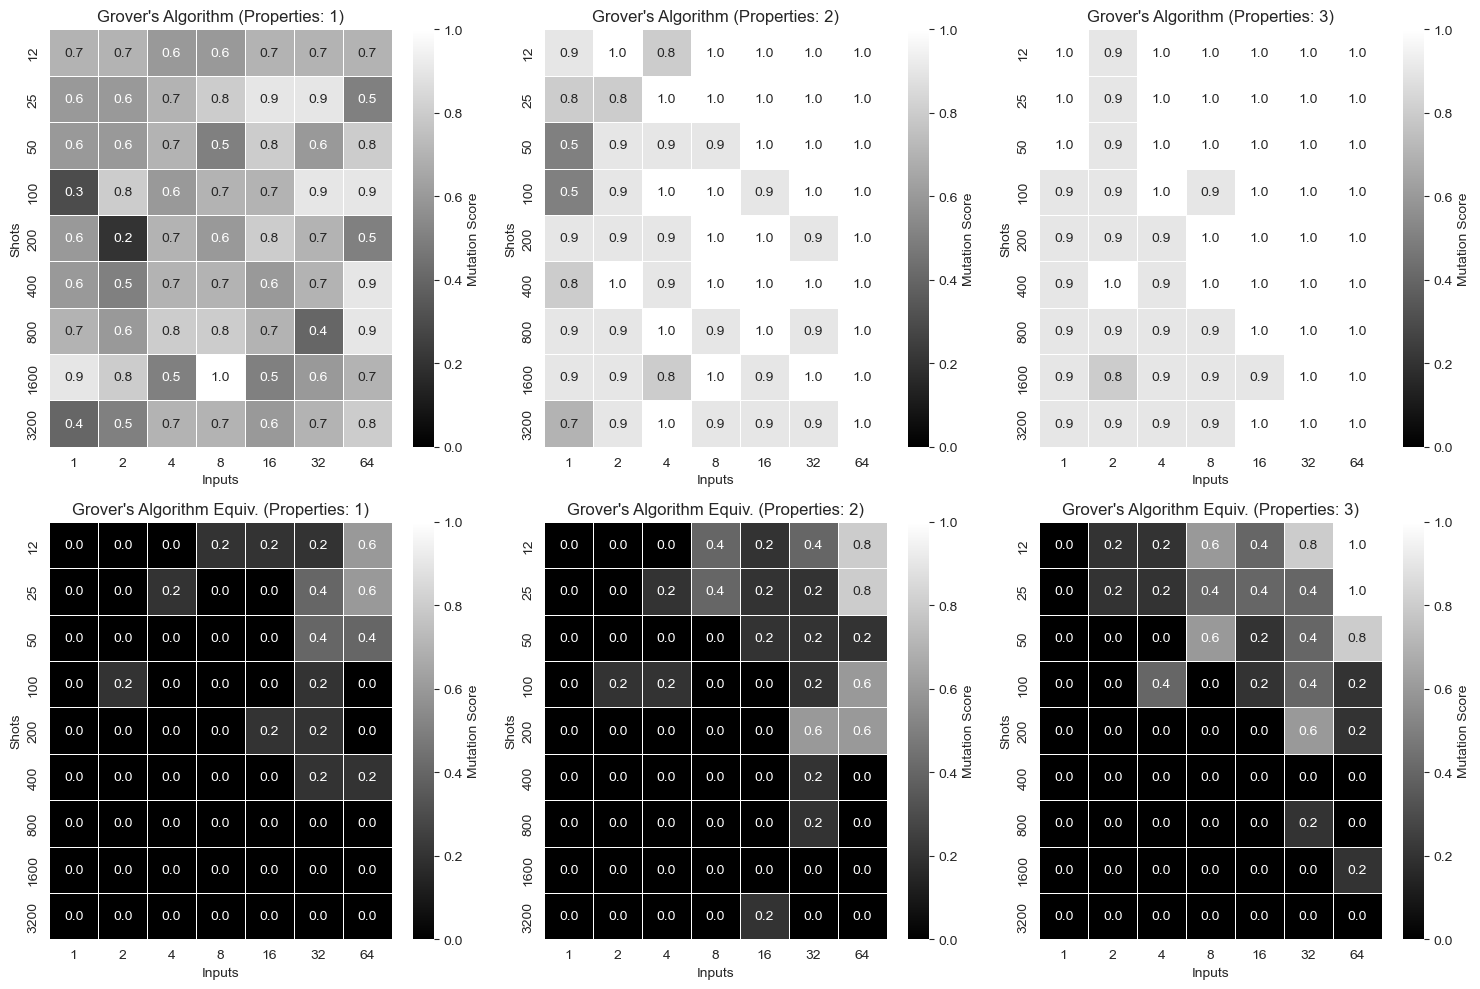

In [46]:
plot_failures(grover_df, "Grover's Algorithm")

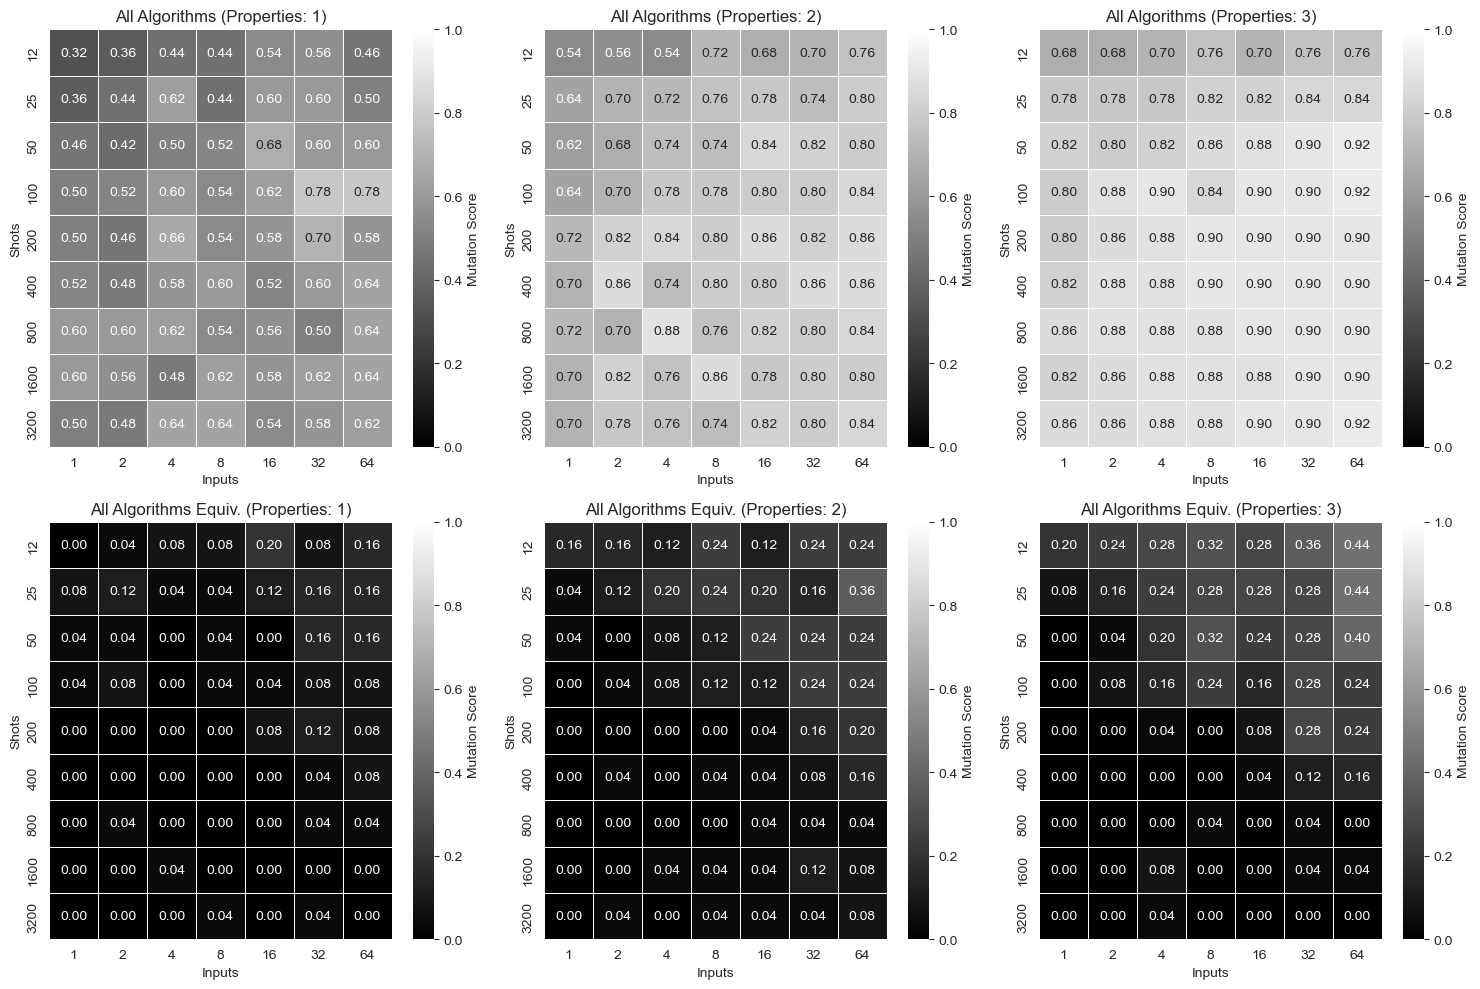

In [47]:
plot_failures(all_df, "All Algorithms", dp_format=".2f")

In [28]:
def plot_time_taken(df, algorithm_name):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # viridis or magma
    palette = sns.color_palette("viridis", as_cmap=True)

    sum_non_equiv_times = []
    # store the max sum time taken non equivalent
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        # get the largest value from the unstacked dataframe
        largest_value = failure_rate.max().max()
        sum_non_equiv_times.append(largest_value)
    max_time_non_equiv = max(sum_non_equiv_times)
        
    sum_equiv_times = []
    # store the max sum time taken equivalent
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        largest_value = failure_rate.max().max()
        sum_equiv_times.append(largest_value)
    max_time_equiv = max(sum_equiv_times)
        

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        
        sns.heatmap(failure_rate, annot=True, cmap=palette, ax=axes[0, i], fmt='.2f', 
                    linewidth=0.5, vmin=0, vmax=max_time_non_equiv, cbar_kws={'label': 'Time Taken (s)'}, 
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        
        sns.heatmap(pass_rate, annot=True, cmap=palette, ax=axes[1, i], fmt='.2f', 
                    linewidth=0.5, vmin=0, vmax=max_time_equiv, cbar_kws={'label': 'Time Taken (s)'}, 
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')

    plt.tight_layout()
    plt.savefig(f"{algorithm_name.replace(' ', '_')}_time_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_time_taken(qt_df, "Quantum Teleportation")
plot_time_taken(dj_df, "Deutsch-Jozsa")
plot_time_taken(qft_df, "Quantum Fourier Transform")
plot_time_taken(qft_df, "Quantum Phase Estimation")
plot_time_taken(grover_df, "Grover's Algorithm")

SyntaxError: f-string: unmatched '(' (776952141.py, line 56)

In [ ]:
def read_merged_data_to_dataframe(algorithm_name, csv_filename):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{csv_filename}.csv"
    return pd.read_csv(filename)

qs_qt_df = read_merged_data_to_dataframe("quantum_teleportation", "QTQS_in_out")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_quantitative_analysis_comparison(qs_qt_df, qt_df, feature_str):
    # Define configurations
    configs = [
        {'measurements': 1600, 'inputs': 32},
        {'measurements': 3200, 'inputs': 32},
        {'measurements': 1600, 'inputs': 64},
        {'measurements': 3200, 'inputs': 64}
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Comparison of Q# and Qiskit mutation testing of quantum teleportation', fontsize=16)
    
    for idx, config in enumerate(configs):
        ax = axes[idx // 2, idx % 2]
        
        # Filter data for the current configuration
        qs_qt_df_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == config['measurements']) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]
        
        # Filter data for the current configuration
        qt_df_filtered = qt_df[
            (qt_df['Number of Measurements'] == config['measurements']) &
            (qt_df['Number of Inputs'] == config['inputs'])
        ]
                
        # Q# results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures = (qs_qt_df_non_equivalent["Result"] == 'Fail').sum()
        
        qs_qt_df_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures = (qs_qt_df_equivalent["Result"] == 'Fail').sum()
        
        # Qiskit results
        qt_df_non_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_m')]
        qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').sum()
        
        qt_df_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_em')]
        qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').sum()
        
        # Prepare data for plotting
        algorithms = ["Non-Equivalent", "Equivalent"]
        qiskit_results = np.array([qt_non_equiv_failures, qt_equiv_failures])
        qs_results = np.array([qs_non_equiv_failures, qs_equiv_failures])
        
        # Create the plot
        x = np.arange(len(algorithms))
        width = 0.35
        
        rects1 = ax.bar(x - width/2, qiskit_results, width, label='Qiskit', alpha=0.8)
        rects2 = ax.bar(x + width/2, qs_results, width, label='Q#', alpha=0.8)
        
        ax.set_ylabel('Property Failures')
        ax.set_title(f'Measurements: {config["measurements"]}, Inputs: {config["inputs"]}')
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)
        ax.legend()
        
        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)
        
        ax.set_ylim(0, max(qiskit_results.max(), qs_results.max()) * 1.2)
        ax.grid(False)
    
    plt.tight_layout()
    # plt.show()

# To use this function, uncomment the following lines and run the script:
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
plot_quantitative_analysis_comparison(df1, df2, "Result")

In [ ]:
# plot the result for quantum teleportation, comparing QS and no QS
def plot_quantitative_analysis_comparison(feature_str):
    # get the number of failures for qs_qt_df
    qs_qt_df_non_equivalent = qs_qt_df[qs_qt_df['Mutant Name'].str.contains('_m')]
    qs_non_equiv_failures = (qs_qt_df_non_equivalent["Result"] == 'Fail').sum()
    
    qs_qt_df_equivalent = qs_qt_df[qs_qt_df['Mutant Name'].str.contains('_em')]
    qs_equiv_failures = (qs_qt_df_equivalent["Result"] == 'Fail').sum()
    
    # get the number of failures for qt_df
    qt_df_non_equivalent = qt_df[qt_df['Mutant Name'].str.contains('_m')]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['Number of Measurements'] == 2000]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['Number of Inputs'] == 25]
    qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').sum() 
    
    qt_df_equivalent = qt_df[qt_df['Mutant Name'].str.contains('_em')]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['Number of Measurements'] == 2000]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['Number of Inputs'] == 25]
    qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').sum() 

    algorithms = ["Quantum Teleportation"]
    
    algorithms_results_qiskit_non_equiv = np.array([qt_non_equiv_failures])
    algorithms_results_qs_non_equiv = np.array([qs_non_equiv_failures])
    algorithms_results_qiskit_equiv = np.array([qt_equiv_failures])
    algorithms_results_qs_equiv = np.array([qs_equiv_failures])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 10))
    width = 0.25
    
    # Define x-positions for the bars
    x = np.arange(len(algorithms))
    
    # Create the bars for non-equivalent mutants
    rects1 = ax1.bar(x - width/2, algorithms_results_qiskit_non_equiv, width, label='Qiskit', alpha=0.8)
    rects2 = ax1.bar(x + width/2, algorithms_results_qs_non_equiv, width, label='Q#', alpha=0.8)
    
    # Customize the plot for non-equivalent mutants
    ax1.set_ylabel('Property Failures')
    ax1.set_title('Comparison of Q# and Qiskit mutation testing\nNon-equivalent mutants')
    ax1.set_xticks(x)
    ax1.set_xticklabels(algorithms)
    ax1.legend()
    
    # Add value labels on the bars
    ax1.bar_label(rects1, padding=3)
    ax1.bar_label(rects2, padding=3)
    
    ax1.set_ylim(0, 10) 
    ax1.grid(False)
    
    # Create the bars for equivalent mutants
    rects3 = ax2.bar(x - width/2, algorithms_results_qiskit_equiv, width, label='Qiskit', alpha=0.8)
    rects4 = ax2.bar(x + width/2, algorithms_results_qs_equiv, width, label='Q#', alpha=0.8)
    
    # Customize the plot for equivalent mutants
    ax2.set_ylabel('Property Failures')
    ax2.set_xlabel('Algorithms')
    ax2.set_title('Comparison of Q# and Qiskit mutation testing\nEquivalent mutants')
    ax2.set_xticks(x)
    ax2.set_xticklabels(algorithms)
    ax2.legend()
    
    # Add value labels on the bars
    ax2.bar_label(rects3, padding=3)
    ax2.bar_label(rects4, padding=3)
    
    ax2.set_ylim(0, 5) 
    ax2.grid(False)
    
    # Adjust layout and display
    fig.tight_layout()
    plt.show()

# Call the function
plot_quantitative_analysis_comparison("Result")

In [36]:
def split_and_group_dfs(dfs):
    grp_and_split_dfs = []
    for algorithm_df in dfs:
            df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
            df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]
    
            failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
            pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
            
            grp_and_split_dfs.append((failure_rate, pass_rate))
    return grp_and_split_dfs

In [37]:
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]    
dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
split_grouped_dfs = split_and_group_dfs(dfs)

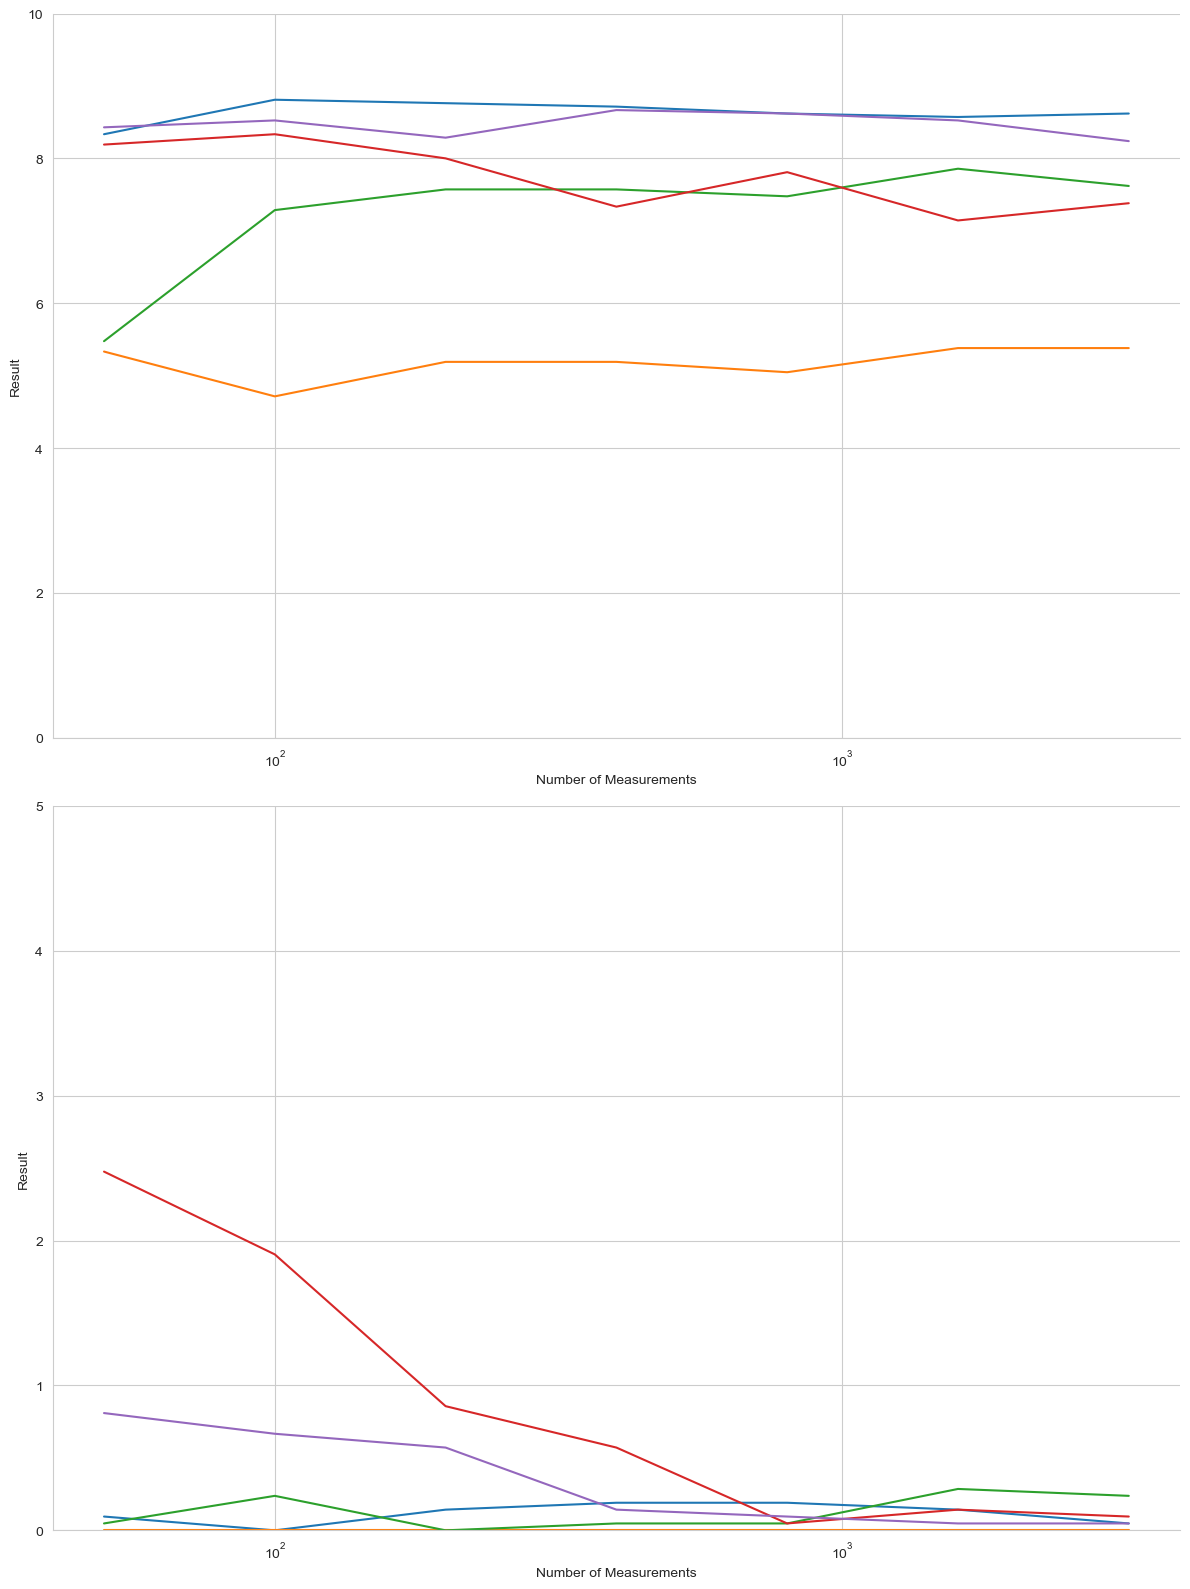

In [38]:
def plot_failures(dfs, algorithm_names, feature_str, log_scale=False):
    # Create a figure with 2 rows and 3 columns
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    ax1.set_ylim(0, 10)
    ax2.set_ylim(0, 5)
        
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')

    for df_non_equivalent, df_equivalent in dfs:
        failure_rate = df_non_equivalent.groupby(feature_str)['Result'].mean().reset_index()
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result")
        
        pass_rate = df_equivalent.groupby(feature_str)['Result'].mean().reset_index()
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result")

    sns.despine()
    plt.tight_layout()
    # plt.savefig(f"{algorithm_name}_failures_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()
    
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]    
dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
plot_failures(split_grouped_dfs, dfs_names, "Number of Measurements", log_scale=True)

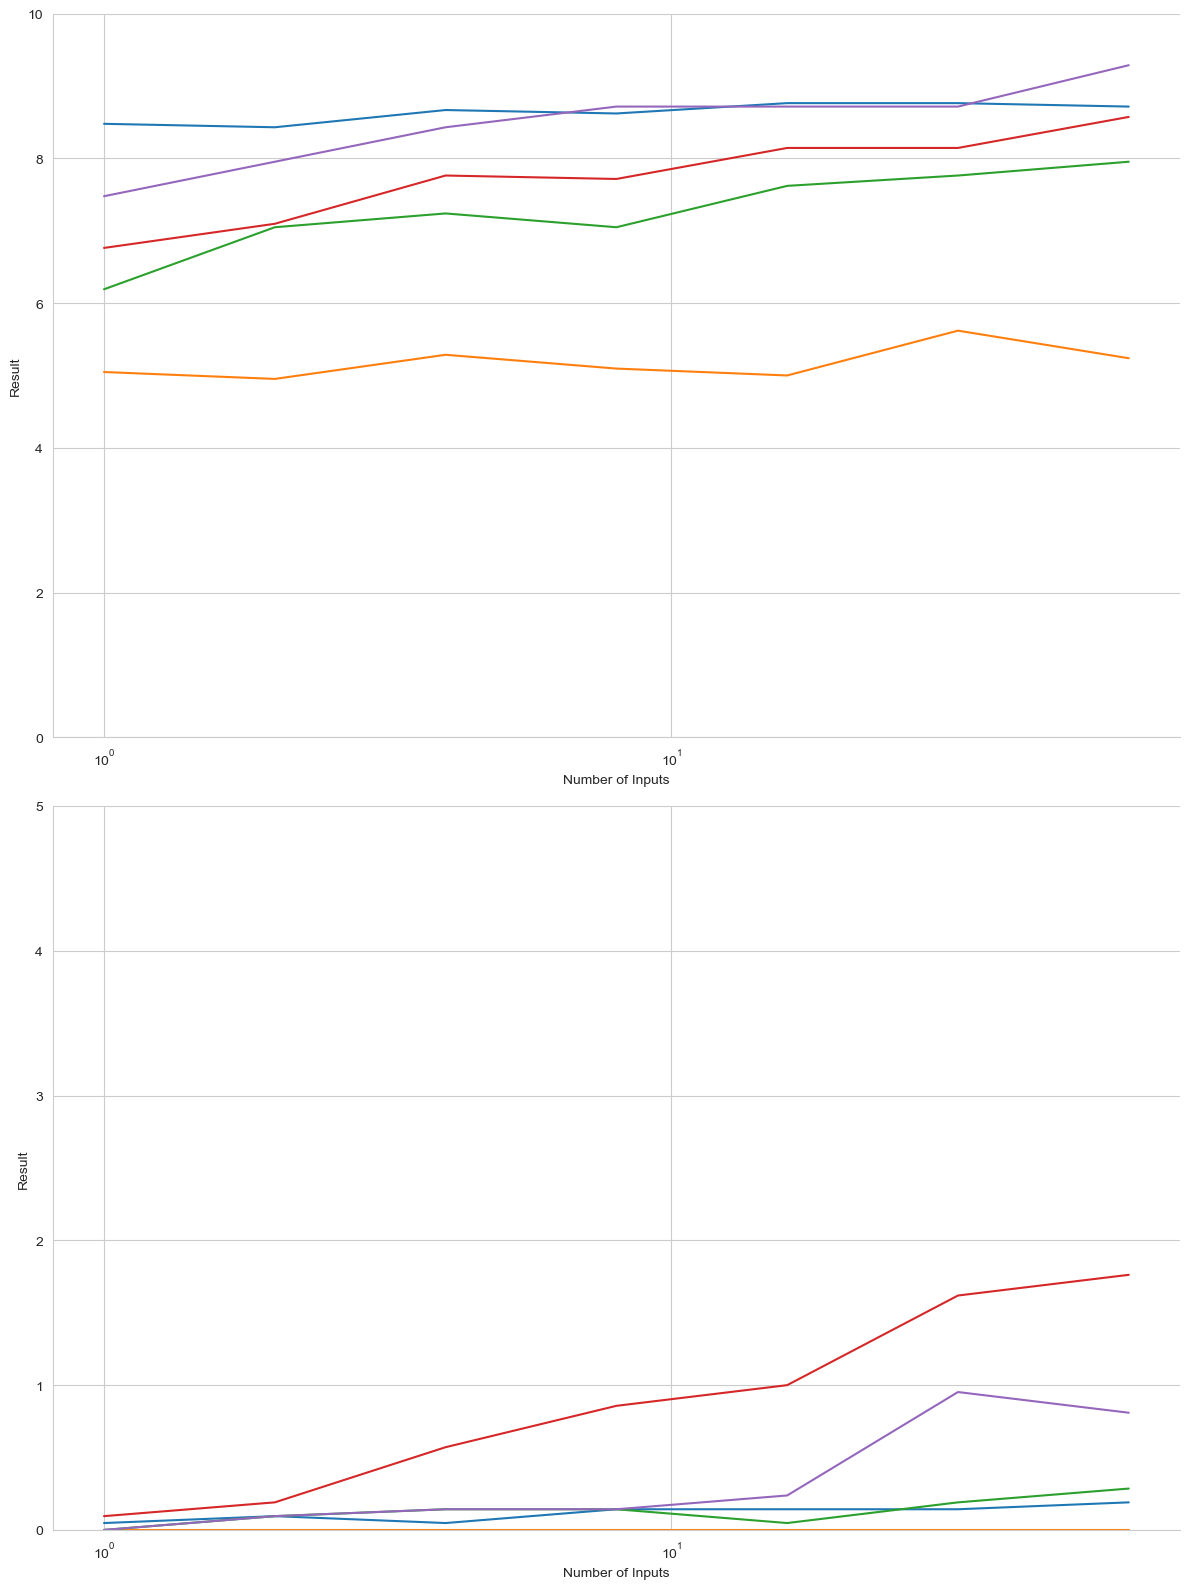

In [39]:
plot_failures(split_grouped_dfs, dfs_names, "Number of Inputs", log_scale=True)

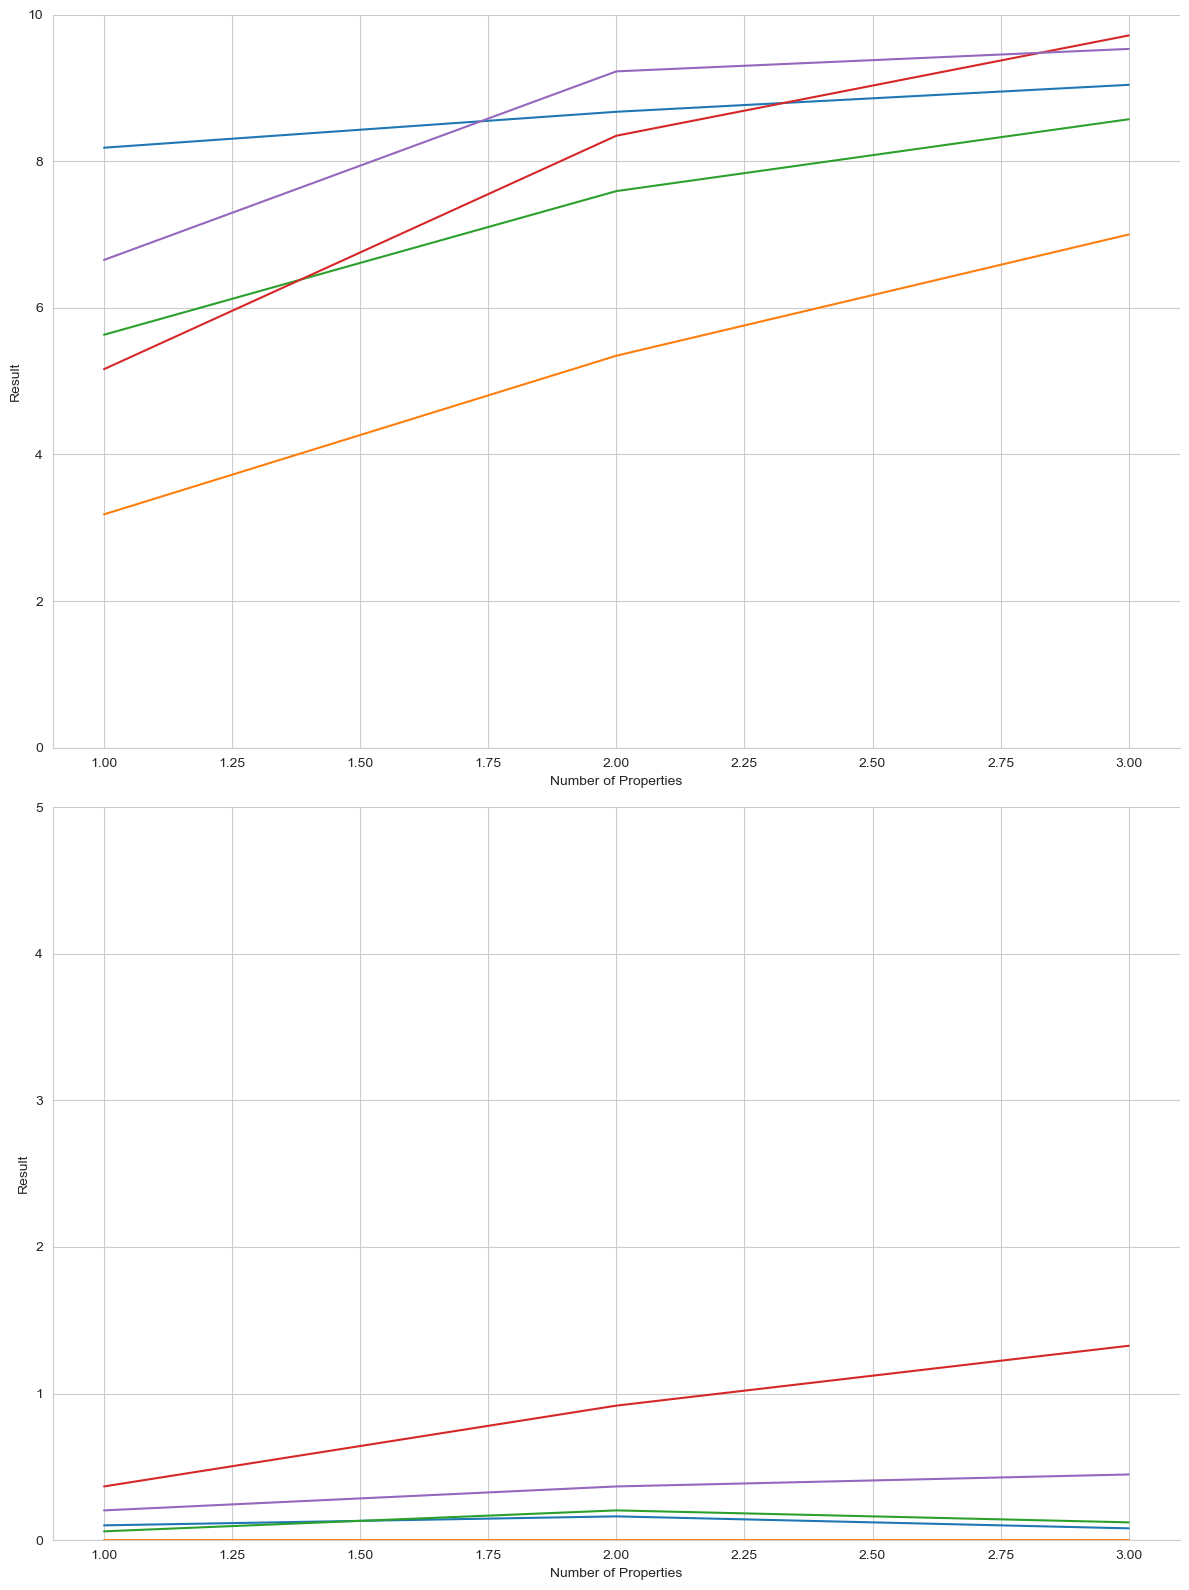

In [40]:
plot_failures(split_grouped_dfs, dfs_names, "Number of Properties", log_scale=False)

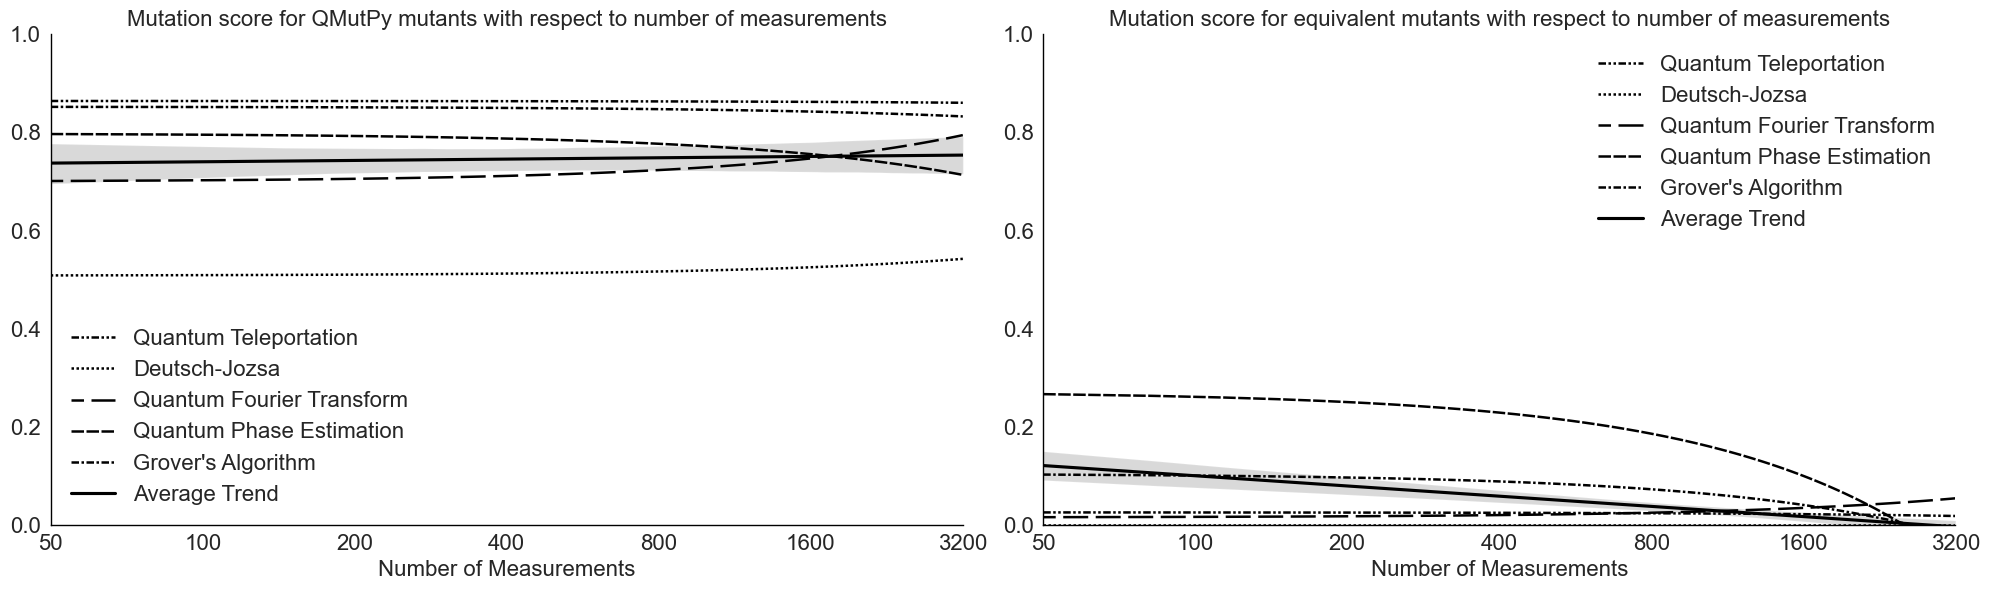

In [48]:
import matplotlib

def plot_failures(dfs, dfs_names, feature_str, log_scale=False, trendline=True):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (0, (3, 1, 1, 1, 1, 1)),       # solid line
        (0, (1, 1)),             # dashed line
        (5, (10, 3)),      # dash-dot line
        (0, (5, 1)),             # dotted line
        (0, (3, 1, 1, 1))      # dash-dot-dot line
    ]
    
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.title.set_text(f'Mutation score for QMutPy mutants with respect to {feature_str.lower()}')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Mutation score for equivalent mutants with respect to {feature_str.lower()}')
    ax2.title.set_fontsize(16)
    
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
    
    if feature_str == "Number of Measurements":
        ticks = [50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]
        
    ax1.set_xlim(ticks[0], ticks[-1])
    
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()
    
    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]

        failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/10.0).reset_index(name='Result')
        # sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar="sd", err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=2, color="red", dashes="dotted")
        # sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])
        sns.regplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label=algorithm_name, ci=None, color="black", scatter=False, line_kws={'linewidth': 1.8, 'linestyle': dash_styles[idx]})
        
        pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/5.0).reset_index(name='Result')
        # sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar="sd", err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=2, color="red", dashes="dotted")
        # sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        sns.regplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label=algorithm_name, ci=None, color="black", scatter=False, line_kws={'linewidth': 1.8, 'linestyle': dash_styles[idx]})
        idx += 1
    
    if trendline:
        all_df = pd.concat(dfs)
        all_df_non_equivalent = all_df[all_df['Mutant Name'].str.contains('_m')]
        all_df_equivalent = all_df[all_df['Mutant Name'].str.contains('_em')]
        
        failure_rate = all_df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/50.0).reset_index(name='Result')
        sns.regplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Average Trend", scatter=False, color="black", logx=log_scale, ci=95)
        
        pass_rate = all_df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/25.0).reset_index(name='Result')
        sns.regplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Average Trend", scatter=False, color="black", logx=log_scale, ci=95)
    

    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()
    
    plt.tight_layout()
    plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]


plot_failures(dfs, dfs_names, "Number of Measurements", log_scale=True)

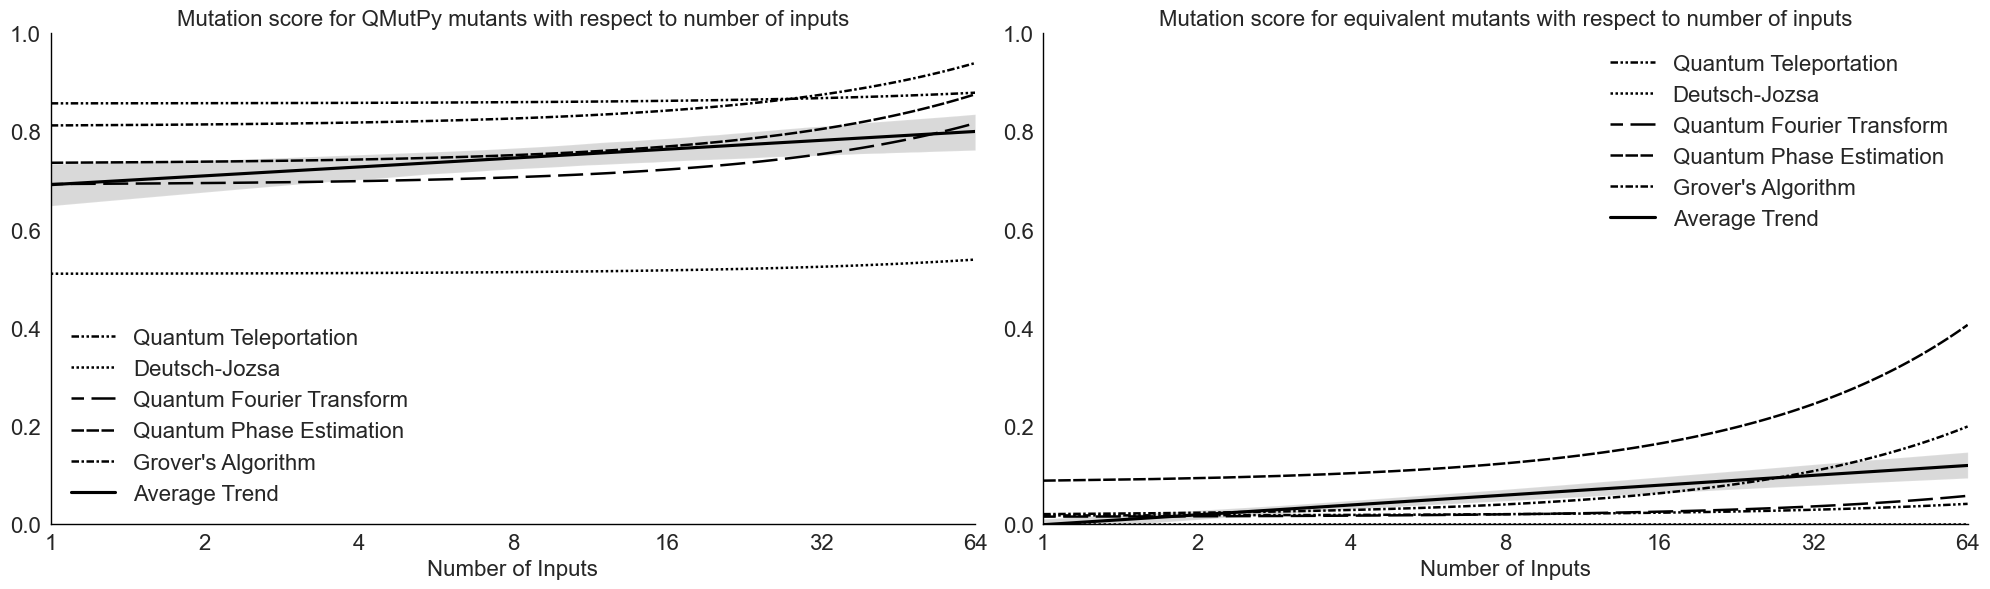

In [49]:
plot_failures(dfs, dfs_names, "Number of Inputs", log_scale=True)

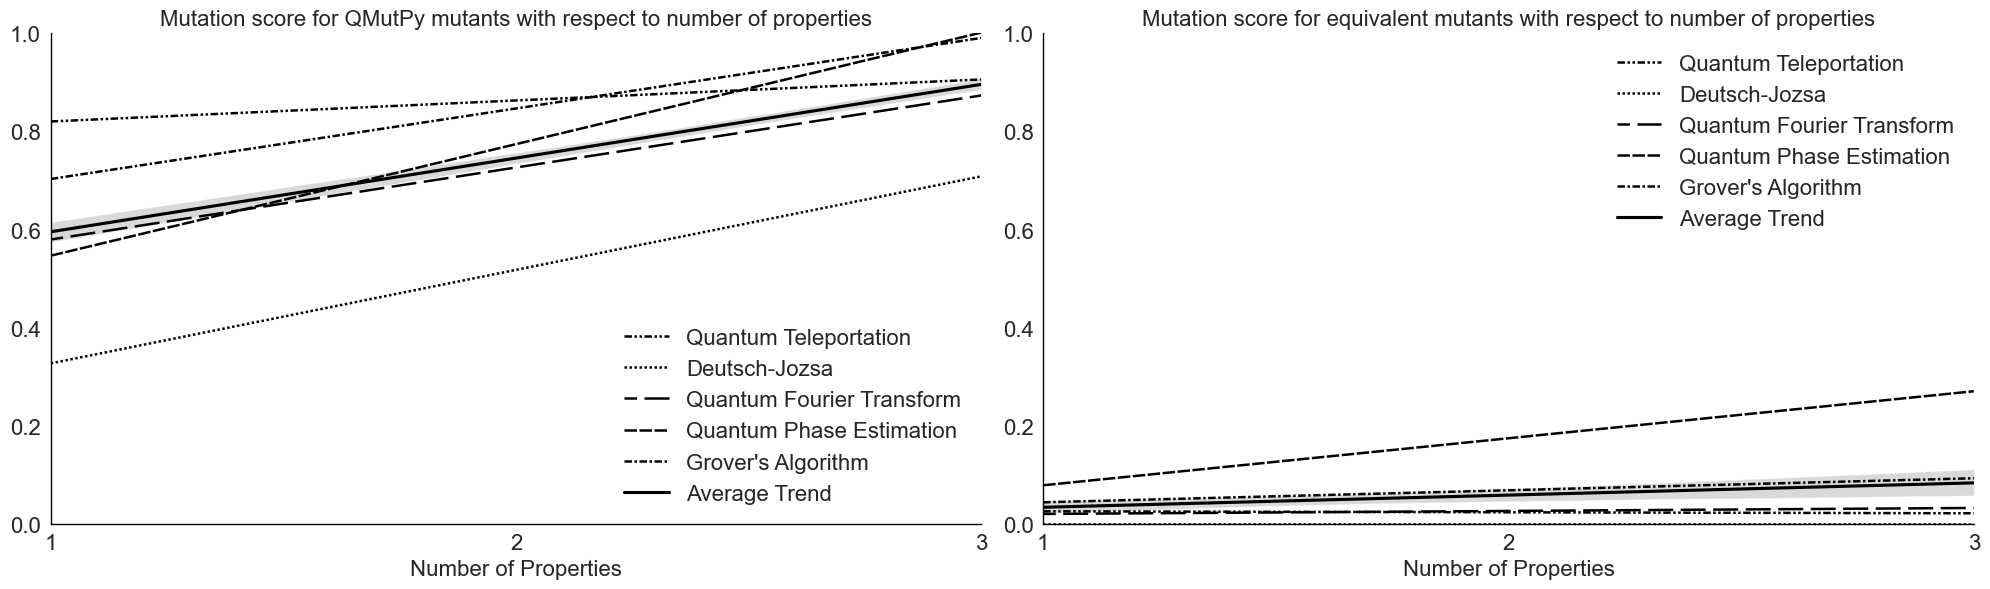

In [50]:
plot_failures(dfs, dfs_names, "Number of Properties", log_scale=False)

C:\Users\gabri\AppData\Local\Temp\ipykernel_24760\121055078.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_non_equivalent['Algorithm Name'] = all_df_non_equivalent['Mutant Name'].str[:-3]


,Number of Measurements,Number of Inputs,Number of Properties,Algorithm Name,Result
0,12,1,1,deutsch_jozsa,0.2
1,12,1,1,grovers_algorithm,0.7
2,12,1,1,quantum_fourier_transform,0.1
3,12,1,1,quantum_phase_estimation,0.3
4,12,1,1,quantum_teleportation,0.3
...,...,...,...,...,...
940,3200,64,3,deutsch_jozsa,0.7
941,3200,64,3,grovers_algorithm,1.0
942,3200,64,3,quantum_fourier_transform,0.9
943,3200,64,3,quantum_phase_estimation,1.0
